In [186]:
import jax
import jax.numpy as jnp
import scipy.sparse
import scipy.sparse.linalg
from jax import config
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

In [187]:
s = 2
r = 0.03
rho = 0.05
Var = 0.07

I = 100
amin = -0.02
amax = 4
a = jnp.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

J = 40
zmean = jnp.exp(Var/2)
Corr = 0.9
the = -jnp.log(Corr)
sig2 = 2*the*Var
zmin = zmean*0.8
zmax = zmean*1.2
z = jnp.linspace(zmin,zmax,J).reshape((1,J))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

mu = (-the * jnp.log(z) + sig2/2)*z
s2 = sig2*z**2

dt = 0.01

In [188]:
def computechi():
    return -jnp.minimum(mu,0)/dz + s2/(2*dz2)
chi = computechi()
#chi.shape = (1,J)

In [189]:
def computeyy():
    return jnp.minimum(mu,0)/dz - jnp.maximum(mu,0)/dz - s2/dz2
yy = computeyy()
#yy.shape = (1,J)

In [190]:
def computezeta():
    return jnp.maximum(mu,0)/dz + s2/(2*dz2)
zeta = computezeta()
# zeta.shape = (1,J)

In [191]:
## compute C
updiag = jnp.tile(zeta[0,0], (I,1))
for j in range(1,J-1):
    updiag = jnp.vstack((updiag, jnp.tile(zeta[0,j], (I,1))))
updiag = jnp.diag(updiag[:,0],k=I)

centdiag = jnp.tile(chi[0,0]+yy[0,0],(I,1))
for j in range(1,J-1):
    centdiag = jnp.vstack((centdiag, jnp.tile(yy[0,j], (I,1))))
centdiag = jnp.vstack((centdiag, jnp.tile(yy[0,J-1]+zeta[0,J-1], (I,1))))
centdiag = jnp.diag(centdiag[:,0])

lowdiag = jnp.tile(chi[0,1], (I,1))
for j in range(2,J):
    lowdiag = jnp.vstack((lowdiag, jnp.tile(chi[0,j], (I,1))))
lowdiag = jnp.diag(lowdiag[:,0], k=-I)

C = lowdiag+centdiag+updiag

In [192]:
def computeVaf(V):
    Vaf = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amax)**(-s)
    Vaf = jnp.vstack([Vaf,re.reshape((40,))])
    return Vaf
def computeVab(V):    
    Vab = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amin)**(-s) 
    Vab = jnp.vstack([re.reshape((40,)),Vab])
    return Vab

In [193]:
def computesf(Vaf):
    cf = Vaf**(-1/s)
    return z + r*a - cf
def computesb(Vab):
    cb = Vab**(-1/s)
    return z + r*a - cb

In [194]:
def computec(Vaf,Vab):
    sf = computesf(Vaf)
    sb = computesb(Vab)
    c0 = z + r*a
    Va0 = c0**(-s)
    If = jnp.where(sf>0, 1, 0)
    Ib = jnp.where(sb<0, 1, 0)
    I0 = (1-If-Ib)
    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
    c = Va_Upwind**(-1/s)
    return c

def computeu(c):
    return c**(1-s)/(1-s)

In [195]:
def constructA(Vaf,Vab):
    sf = computesf(Vaf)
    sb = computesb(Vab)
    X = -jnp.minimum(sb,0)/da   
    Y = -jnp.maximum(sf,0)/da + jnp.minimum(sb,0)/da
    Z = jnp.maximum(sf,0)/da
    
    Z = Z.reshape(-1,order='F')
    A_up = jnp.diag(Z[0:-1],k=1)

    Y = Y.reshape(-1,order='F')
    A_diag = jnp.diag(Y,k=0)

    X = X.reshape(-1,order='F')
    A_down = jnp.diag(X[1:],k=-1)
    
    AA = A_down + A_diag + A_up
    Cswitch = C
    A = AA + Cswitch
    return A

In [196]:
def T_withtime(Vaf,Vab,V):
    """ 
    equation:
        rhov(t,a,z) = maxu(c)+v_a(t,a,z)(z+ra-c)+mu(z)v_z(t,a,z)+sigma^2(z)/2v_zz(t,a,z)+v_t(t,a,z)
    scheme:
        (rho+1/dt-A)v^n = u^{n+1}+(1/dt)v^{n+1}
    """
    A = constructA(Vaf,Vab)
    B = (rho+1/dt)*jnp.eye(I*J)-A
    c = computec(Vaf,Vab)
    u = computeu(c)
    u_stack = u.reshape(-1,order='F')
    V_stack = V.reshape(-1,order='F')
    b = u_stack + V_stack/dt
    v = jax.scipy.linalg.solve(B,b)
    return v

T_withtime_jit = jax.jit(T_withtime)

In [197]:
## terminal condition
v = (z + r*a)**(1-s)/(1-s)/rho
Nt = 100
for ti in range(Nt-2,-1,-1):
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        v = T_withtime(Vaf,Vab,v)
        v = v.reshape((I,J), order='F')
        if ti % 10 == 0: print(ti)

CPU times: total: 0 ns
Wall time: 0 ns
90
80
70
60
50
40
30
20
10
0


In [198]:
## terminal condition
v = (z + r*a)**(1-s)/(1-s)/rho
Nt = 100
for ti in range(Nt-2,-1,-1):
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        v = T_withtime_jit(Vaf,Vab,v)
        v = v.reshape((I,J), order='F')
        if ti % 10 == 0: print(ti)

90
80
70
60
50
40
30
20
10
0


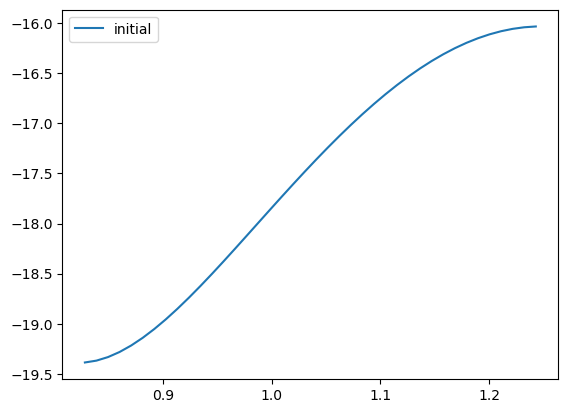

In [199]:
plt.plot(z[0,:],v[-1,:], label='initial')
plt.legend()